# Precipitaion Forecasting
In this project, we have trained different types of machine learning models on some data about weather to predict precipitation.

## Introduction
Weather forecasting is using data about the current state and predict how the atmosphere will change. Weather warnings are used to protect lives and property, weather forecasting improves transportation safety, and precipitation forecasting is important to agriculture. There are many different ways of weather prediction. We have used machine learning models and compared the predicted results with actual values.
#### Study area
Basel is a city in northwest Switzerland. On average 32% of days of the year are rainy or snowy. The total precipitation is around 840 mm annually. May receives the wettest month in Basel with an average of 98 mm of rain.

## Methodology
The following libraries are used.

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline

from preprocessing import get_data, drop_missing_data, change_resolution_to_daily, write_daily_data, read_daily_data
from visualize import show_histogram

At first, data is collected. Then, some preprocessing techniques are used to prepare data for machine learning models. Finally, different machine learning techniquies are applied and the accuracy for each is reported. 

## Dataset
**You can find and download the dataset in [this](https://www.meteoblue.com/en/weather/archive/export) link.**
#### About dataset
This dataset contains some attributes about weather for Basel, from January, 2014 to November, 2023 with hourly resolution. The first nine rows are some basic information about location of city and units of measurements which we do not need it.

In [2]:
data = get_data()
print(f"Number of samples:      {data.shape[0]}")
print(f"Number of features:     {data.shape[1]}")

Number of samples:      86664
Number of features:     7


### Cleaning dataset
There are some rows at the end of dataset which are empty, missing data. We simply drop them. A day after the missing data is not complete. For simplicity we remove this day as well.

In [3]:
missing_data = drop_missing_data(data)
print(f"Number of missing rows: {missing_data}")
print(f"Number of samples:      {data.shape[0]}")

Number of missing rows: 191
Number of samples:      86472


## Features
In our data, each row represents a sample and each column represents a feature. Here is the list of columns
- Temperature (T)
- Precipitation Total (PT)
- Relative Humidity (RH)
- Wind Speed (WS)
- Wind Direction (WD)
- Cloud Cover Total (CCT)
- Mean Sea Level Pressure (MSLP)

measured hourly. PT is actually the target value. This list is raw and we will do some operations to get ready for models.

### Make samples daily
Forecasting for a whole day is more general than one hour, so we decide to merge each 24 examples to convert the resolution to daily. A good questio is how? One way is to get mean for each feature.
- Specifically for temperature, having maximum, minimum, and mean is better.
- Precipitation should be the sum instead of mean.
- Now we have 9 columns(features) and 3603 rows(samples).

In [4]:
daily_data = change_resolution_to_daily(data)
daily_data

Variable           MEANT    PT         RH         WS          WD        CCT  \
Year Month Day                                                                
2014 1     1    4.494412   1.4  90.203694  16.615975  166.495278  59.916667   
           2    5.978995   6.8  92.044333  20.621631  184.099628  63.875000   
           3    6.586079   0.8  88.778159  22.263927  183.268500  50.108334   
           4    6.358579  16.5  94.172092  15.272616  158.277724  66.666667   
           5    4.995662   5.5  86.622807  16.897822  225.090521  59.383333   
...                  ...   ...        ...        ...         ...        ...   
2023 11    8    7.268995   0.0  82.063136  17.965620  202.643658  33.016667   
           9    7.729829   4.2  82.235617  25.143419  196.132513  69.020834   
           10   9.101078   9.3  76.940065  27.342357  228.518643  61.875000   
           11   7.350245   3.2  82.186650  22.030794  242.243293  49.875000   
           12   5.818162  14.0  93.582846  18.648649  181.010854  85.333333   

Variable               MSLP       MAXT      MINT  
Year Month Day                                    
2014 1     1    1014.029167   8.720245  0.310245  
           2    1008.670833   9.240245  3.530245  
           3    1013.070833  10.400246  2.340245  
           4    1007.625000   8.480246  4.600245  
           5    1010.754167   7.480245  0.440245  
...                     ...        ...       ...  
2023 11    8    1019.379167  12.380245  3.760245  
           9    1010.795833  10.380245  3.690246  
           10   1005.745833  10.670245  7.960245  
           11   1010.391667   8.660245  4.260245  
           12   1010.112500  11.230246  2.140245  

[3603 rows x 9 columns]

For saving time, we write daily data in a file.

In [5]:
write_daily_data(daily_data)

In [6]:
_, FEATURES, X, y = read_daily_data()

### Splitting data


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42)
print(f"X_teset shape:  {X_test.shape}")
print(f"X_train shape:  {X_train.shape}")
print(f"y_teset shape:  {y_test.shape}")
print(f"y_train shape:  {y_train.shape}")
X_train

X_teset shape:  (2523, 8)
X_train shape:  (1080, 8)
y_teset shape:  (2523,)
y_train shape:  (1080,)


MEANT         RH         WS          WD        CCT  \
Year Month Day                                                           
2014 5     12   10.161495  75.458657  21.404837  242.671985  69.833333   
     3     19   11.828162  58.017729  13.438973  235.903322  44.433333   
2019 8     15   17.733579  69.792227  15.702876  228.086865  51.600000   
2015 12    26    5.426495  90.986576  11.958316  184.758942   3.200000   
2017 8     7    20.725662  53.785066  10.929408   70.491766   2.441667   
...                   ...        ...        ...         ...        ...   
     2     4     5.024829  85.869119  24.204255  179.447189  66.295834   
     7     18   24.878995  56.323168  11.088339  103.813559  24.375000   
2016 5     10   17.901079  75.293719  11.359284  103.684676  54.058334   
2023 8     9    19.143579  67.030656  12.944931  228.231707  65.750000   
2022 9     10   16.446912  78.822349  19.900548  245.836992  74.291667   

                       MSLP       MAXT       MINT  
Year Month Day                                     
2014 5     12   1016.058333  13.080245   7.950245  
     3     19   1026.195833  15.860246   6.440245  
2019 8     15   1016.733333  22.740246  11.790245  
2015 12    26   1031.970833  11.720245   2.420245  
2017 8     7    1016.754167  28.920246  11.620245  
...                     ...        ...        ...  
     2     4    1004.866667   7.800245   1.560245  
     7     18   1015.975000  32.180244  15.780245  
2016 5     10   1008.637500  22.180244  14.800245  
2023 8     9    1018.466667  23.950245  14.990245  
2022 9     10   1017.754167  19.010244  14.810246  

[1080 rows x 8 columns]

### Visualize parameters distribution
A [histogram](https://www.investopedia.com/terms/h/histogram.asp#:~:text=A%20histogram%20is%20a%20graph,how%20often%20that%20variable%20appears) is a graph that shows the frequency of numerical data using rectangles. The height of each rectangle represents the distribution frequency of a variable. The width of the rectangle represents the value of the variable. Here is the histogram for features and target value.

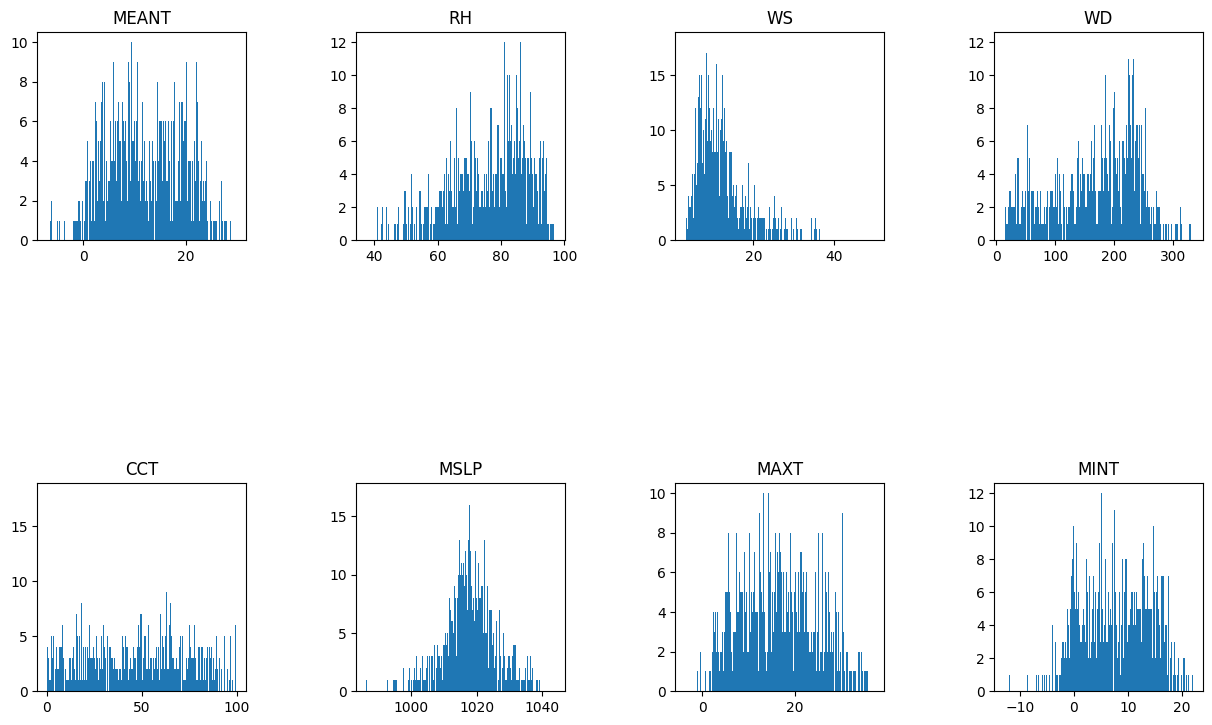

In [8]:
show_histogram(X_train.values)

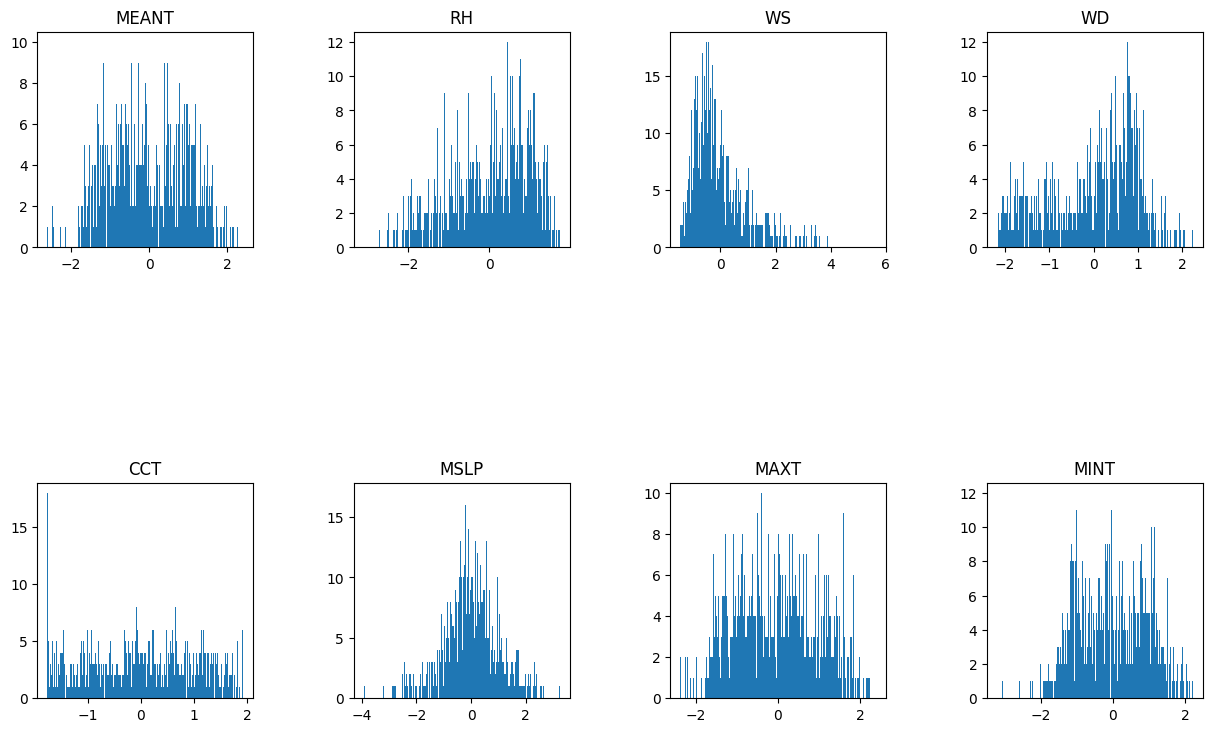

In [9]:
stnd_s = StandardScaler()

## Models
We start by Linear Model.

### Linear Model
In this model, target value is expected to be a linear combination of the features.

In [25]:
linear_reg = SGDRegressor(loss="squared_error", penalty="l2", alpha=0.00001, max_iter=1, random_state=42)
linear_reg.fit(X_train, y_train)
pd.DataFrame(linear_reg.coef_[0], columns=FEATURES, index=["Coefficients"])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


,MEANT,RH,WS,WD,CCT,MSLP,MAXT,MINT
Coefficients,1.703313e+11,1.703313e+11,1.703313e+11,1.703313e+11,1.703313e+11,1.703313e+11,1.703313e+11,1.703313e+11


In [ ]:
import torch
import torch.nn as nn


class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(20000, 1)
        # self.linear2 = nn.Linear(10000,5000)
        # self.linear3 = nn.Linear(5000, 2500)
        # self.linear4 = nn.Linear(2500, 1250)
        # self.linear5 = nn.Linear(1250, 625)
        # self.linear6 = nn.Linear(625, 125)
        # self.linear7 = nn.Linear(125, 1)
        
    def forward(self, xb):
        xb.to(device)
        out = self.linear1(xb.to(device)).to(device)
        # out = self.linear2(out.to(device)).to(device)
        # out = self.linear3(out.to(device)).to(device)
        # out = self.linear4(out.to(device)).to(device)
        # out = self.linear5(out.to(device)).to(device)
        # out = self.linear6(out.to(device)).to(device)
        # out = self.linear7(out.to(device)).to(device)
        return out

### Other Models
This is like ...
If we apply it, results:
###### SOME FIGUERS AND PLOTS TO SHOW THE RESULTS
Calculate performance, error, advantages and disadvantages

## Conclusion
- Forecasting is good.
- Undestand that these features have a stronger affect in result.
- This Model is better in performance.
- Add references if necessary.